# Support Vector Machine vs Random Forest 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow import keras

2023-04-17 09:07:35.130379: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 09:07:35.170973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Datasets

## Tic-Tac-Toe End Game

1. Relevant Information:
  This database encodes the complete set of possible board configurations
  at the end of tic-tac-toe games, where "x" is assumed to have played
  first.  The target concept is "win for x" (i.e., true when "x" has one
  of 8 possible ways to create a "three-in-a-row"). Interestingly, this raw database gives a stripped-down decision tree
  algorithm (e.g., ID3) fits.  However, the rule-based CN2 algorithm, the
  simple IB1 instance-based learning algorithm, and the CITRE 
  feature-constructing decision tree algorithm perform well on it.

2. Number of Instances: 958 (legal tic-tac-toe endgame boards)

3. Number of Attributes: 9, each corresponding to one tic-tac-toe square

4. Attribute Information: (x=player x has taken, o=player o has taken, b=blank)

   1. top-left-square: {x,o,b}
   2. top-middle-square: {x,o,b}
   3. top-right-square: {x,o,b}
   4. middle-left-square: {x,o,b}
   5. middle-middle-square: {x,o,b}
   6. middle-right-square: {x,o,b}
   7. bottom-left-square: {x,o,b}
   8. bottom-middle-square: {x,o,b}
   9. bottom-right-square: {x,o,b}
  10. Class: {positive,negative}

5. Missing Attribute Values: None

In [2]:
column_names = ['upper_left', 'upper_middle','upper_right','middle_left', 'middle_middle','middle_right','lower_left', 'lower_middle','lower_right', 'target']

ttt_df = pd.read_csv('tic-tac-toe.data', names=column_names)
ttt_df

upper_left upper_middle upper_right middle_left middle_middle  \
0            x            x           x           x             o   
1            x            x           x           x             o   
2            x            x           x           x             o   
3            x            x           x           x             o   
4            x            x           x           x             o   
..         ...          ...         ...         ...           ...   
953          o            x           x           x             o   
954          o            x           o           x             x   
955          o            x           o           x             o   
956          o            x           o           o             x   
957          o            o           x           x             x   

    middle_right lower_left lower_middle lower_right    target  
0              o          x            o           o  positive  
1              o          o            x           o  positive  
2              o          o            o           x  positive  
3              o          o            b           b  positive  
4              o          b            o           b  positive  
..           ...        ...          ...         ...       ...  
953            o          o            x           x  negative  
954            o          x            o           x  negative  
955            x          x            o           x  negative  
956            x          x            o           x  negative  
957            o          o            x           x  negative  

[958 rows x 10 columns]

In [3]:
ttt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   upper_left     958 non-null    object
 1   upper_middle   958 non-null    object
 2   upper_right    958 non-null    object
 3   middle_left    958 non-null    object
 4   middle_middle  958 non-null    object
 5   middle_right   958 non-null    object
 6   lower_left     958 non-null    object
 7   lower_middle   958 non-null    object
 8   lower_right    958 non-null    object
 9   target         958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


In [4]:
ttt_df.isnull().sum()

upper_left       0
upper_middle     0
upper_right      0
middle_left      0
middle_middle    0
middle_right     0
lower_left       0
lower_middle     0
lower_right      0
target           0
dtype: int64

In [5]:
for i in ttt_df.columns:
    if i == 'target':
        ttt_df[i] = ttt_df[i].map({
            'negative':0,
            'positive':1,
        })
    else:
        dummies = pd.get_dummies(ttt_df[i], prefix=i)
        ttt_df = pd.concat([ttt_df, dummies], axis=1)
        ttt_df = ttt_df.drop(i, axis=1)
        # ttt_df[i] = ttt_df[i].map({
        #     'b':0,
        #     'o':1,
        #     'x':2
        # })

In [6]:
ttt_df

target  upper_left_b  upper_left_o  upper_left_x  upper_middle_b  \
0         1             0             0             1               0   
1         1             0             0             1               0   
2         1             0             0             1               0   
3         1             0             0             1               0   
4         1             0             0             1               0   
..      ...           ...           ...           ...             ...   
953       0             0             1             0               0   
954       0             0             1             0               0   
955       0             0             1             0               0   
956       0             0             1             0               0   
957       0             0             1             0               0   

     upper_middle_o  upper_middle_x  upper_right_b  upper_right_o  \
0                 0               1              0              0   
1                 0               1              0              0   
2                 0               1              0              0   
3                 0               1              0              0   
4                 0               1              0              0   
..              ...             ...            ...            ...   
953               0               1              0              0   
954               0               1              0              1   
955               0               1              0              1   
956               0               1              0              1   
957               1               0              0              0   

     upper_right_x  ...  middle_right_x  lower_left_b  lower_left_o  \
0                1  ...               0             0             0   
1                1  ...               0             0             1   
2                1  ...               0             0             1   
3                1  ...               0             0             1   
4                1  ...               0             1             0   
..             ...  ...             ...           ...           ...   
953              1  ...               0             0             1   
954              0  ...               0             0             0   
955              0  ...               1             0             0   
956              0  ...               1             0             0   
957              1  ...               0             0             1   

     lower_left_x  lower_middle_b  lower_middle_o  lower_middle_x  \
0               1               0               1               0   
1               0               0               0               1   
2               0               0               1               0   
3               0               1               0               0   
4               0               0               1               0   
..            ...             ...             ...             ...   
953             0               0               0               1   
954             1               0               1               0   
955             1               0               1               0   
956             1               0               1               0   
957             0               0               0               1   

     lower_right_b  lower_right_o  lower_right_x  
0                0              1              0  
1                0              1              0  
2                0              0              1  
3                1              0              0  
4                1              0              0  
..             ...            ...            ...  
953              0              0              1  
954              0              0              1  
955              0              0              1  
956              0              0              1  
957              0              0              1  

[958

### Most number of wins

In [7]:
x_wins = ttt_df.loc[ttt_df['target'] == 1]
# wins and middle middle


In [8]:

i = x_wins[['middle_middle_x', 'target']].groupby(['middle_middle_x'], as_index=False).count()

i

middle_middle_x  target
0                0     260
1                1     366

In [9]:
num_of_wins = []
features = [column+'_x' for column in column_names[:-1]]
for feature in features:
    i = x_wins[[feature, 'target']].groupby([feature], as_index=False).count()
    num_of_wins.append(list(i.target.values)[-1:][0])

win_count = pd.DataFrame({
    'number of wins':num_of_wins
}, index=features)

win_count

number of wins
upper_left_x                295
upper_middle_x              225
upper_right_x               295
middle_left_x               225
middle_middle_x             366
middle_right_x              225
lower_left_x                295
lower_middle_x              225
lower_right_x               295

<Axes: >

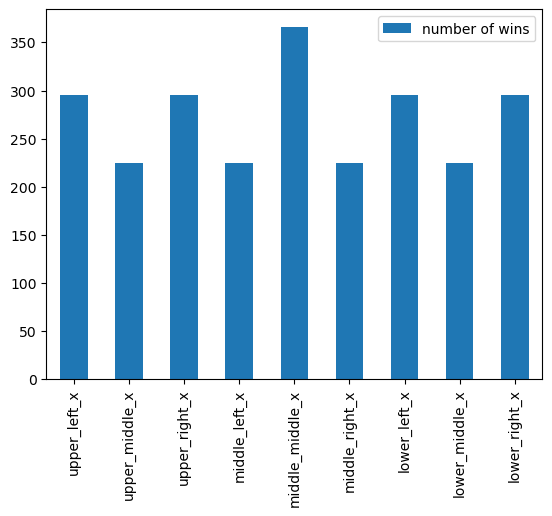

In [10]:

win_count.plot.bar()

In [11]:
x_not_wins = ttt_df.loc[ttt_df['target'] == 0]

num_of_not_wins= []
features = [column+'_o' for column in column_names[:-1]]
for feature in features:
    i = x_not_wins[[feature, 'target']].groupby([feature], as_index=False).count()
    num_of_not_wins.append(list(i.target.values)[-1:][0])

loss_or_draw = pd.DataFrame({
    'count':num_of_not_wins
}, index=features)

loss_or_draw

count
upper_left_o       146
upper_middle_o     101
upper_right_o      146
middle_left_o      101
middle_middle_o    192
middle_right_o     101
lower_left_o       146
lower_middle_o     101
lower_right_o      146

<Axes: >

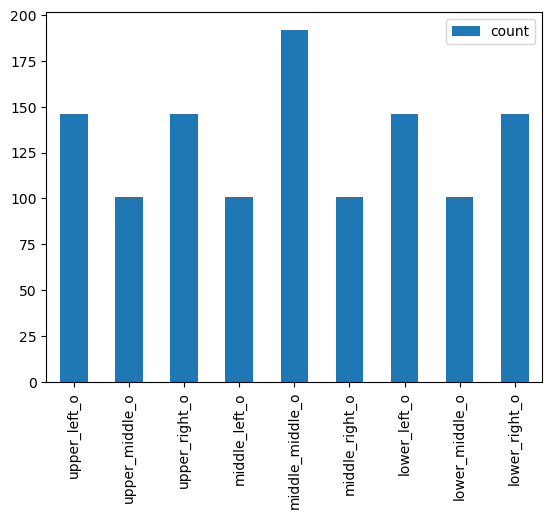

In [12]:

loss_or_draw.plot.bar()

In [13]:

ttt_df

target  upper_left_b  upper_left_o  upper_left_x  upper_middle_b  \
0         1             0             0             1               0   
1         1             0             0             1               0   
2         1             0             0             1               0   
3         1             0             0             1               0   
4         1             0             0             1               0   
..      ...           ...           ...           ...             ...   
953       0             0             1             0               0   
954       0             0             1             0               0   
955       0             0             1             0               0   
956       0             0             1             0               0   
957       0             0             1             0               0   

     upper_middle_o  upper_middle_x  upper_right_b  upper_right_o  \
0                 0               1              0              0   
1                 0               1              0              0   
2                 0               1              0              0   
3                 0               1              0              0   
4                 0               1              0              0   
..              ...             ...            ...            ...   
953               0               1              0              0   
954               0               1              0              1   
955               0               1              0              1   
956               0               1              0              1   
957               1               0              0              0   

     upper_right_x  ...  middle_right_x  lower_left_b  lower_left_o  \
0                1  ...               0             0             0   
1                1  ...               0             0             1   
2                1  ...               0             0             1   
3                1  ...               0             0             1   
4                1  ...               0             1             0   
..             ...  ...             ...           ...           ...   
953              1  ...               0             0             1   
954              0  ...               0             0             0   
955              0  ...               1             0             0   
956              0  ...               1             0             0   
957              1  ...               0             0             1   

     lower_left_x  lower_middle_b  lower_middle_o  lower_middle_x  \
0               1               0               1               0   
1               0               0               0               1   
2               0               0               1               0   
3               0               1               0               0   
4               0               0               1               0   
..            ...             ...             ...             ...   
953             0               0               0               1   
954             1               0               1               0   
955             1               0               1               0   
956             1               0               1               0   
957             0               0               0               1   

     lower_right_b  lower_right_o  lower_right_x  
0                0              1              0  
1                0              1              0  
2                0              0              1  
3                1              0              0  
4                1              0              0  
..             ...            ...            ...  
953              0              0              1  
954              0              0              1  
955              0              0              1  
956              0              0              1  
957              0              0              1  

[958

### ML

In [40]:
features = column_names[:-1]
X = ttt_df.drop(['target'], axis=1)
y = ttt_df['target']

In [45]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Split the dataset into train and test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Training an SVM model
svc = svm.SVC(kernel='sigmoid')
svc.fit(X_train, y_train)

# Test the trained SVM model on the test set and compute accuracy
y_pred = svc.predict(X_test)
print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: Precomputed matrix must be a square matrix. Input is a 766x27 matrix.

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Training a random forrest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Test the trained RF model on the test set and compute accuracy
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred))

Random Forest Accuracy: 0.984375


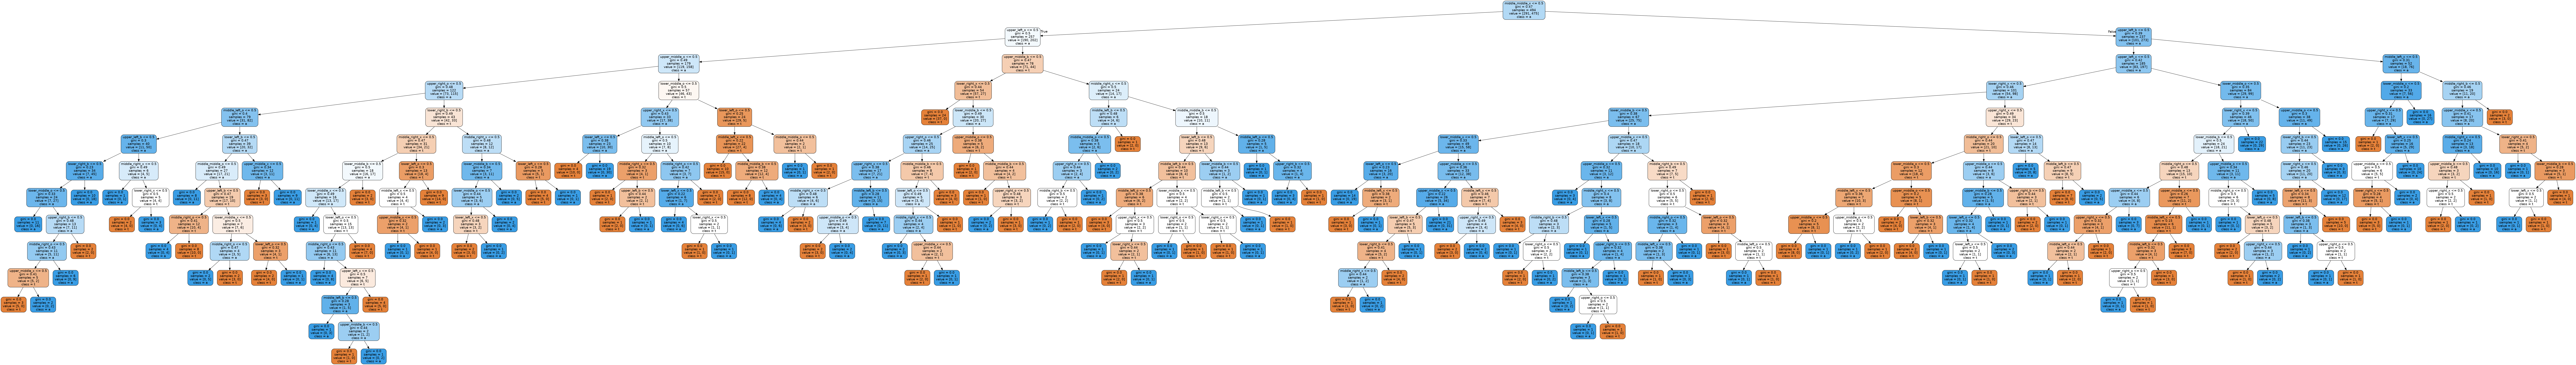

In [17]:
from sklearn.tree import export_graphviz

estimator = rf.estimators_[5]
# Get the column names of X and y
features = X_train.columns.to_list()
target = y_train.name

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Cellphone prices

In [18]:
cp_df = pd.read_csv('train.csv')

In [19]:
cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [20]:
cp_df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [21]:
cp_df.head()

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  
3        1             0     0            2  
4        1             1     0            1  

[5 rows x 21 columns]

<Axes: >

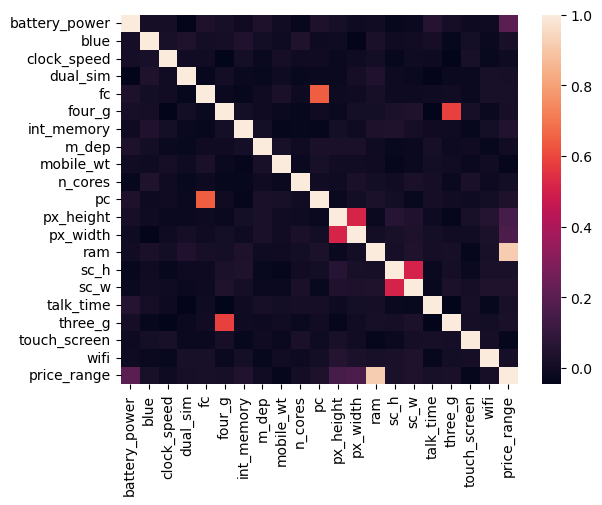

In [22]:
sns.heatmap(cp_df.corr())

In [23]:
cp_df.corr()['price_range'].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

ram has the highest correltion for price_range

In [24]:
cp_df['ram'].describe()

count    2000.000000
mean     2124.213000
std      1084.732044
min       256.000000
25%      1207.500000
50%      2146.500000
75%      3064.500000
max      3998.000000
Name: ram, dtype: float64

<Axes: ylabel='Frequency'>

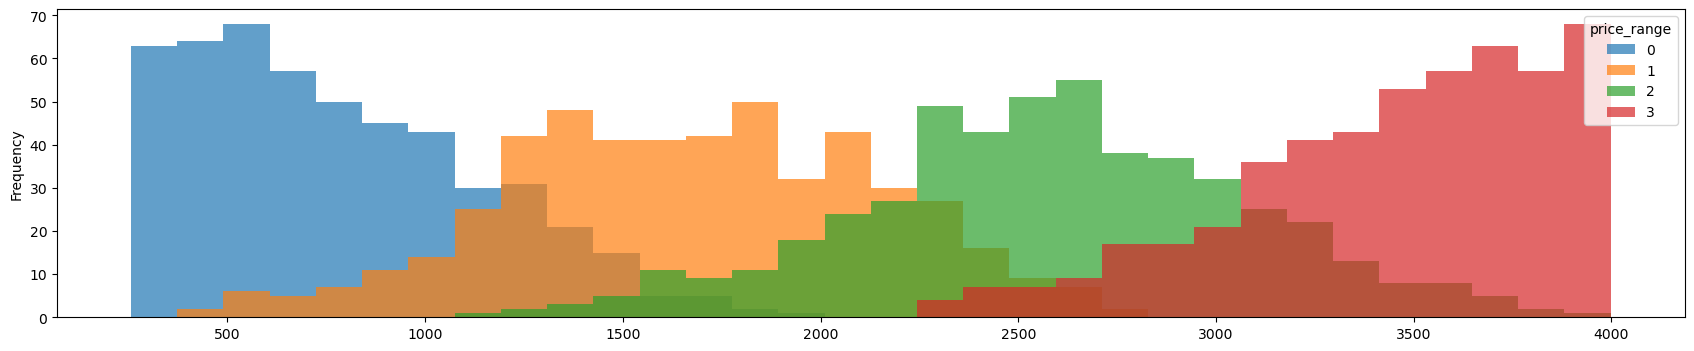

In [25]:
ram_price = cp_df.pivot(columns='price_range', values='ram')
ram_price.plot.hist(bins=32, figsize=(21, 4), alpha=0.7)


Text(0.5, 1.0, 'Scatter plot of ram vs internal memory')

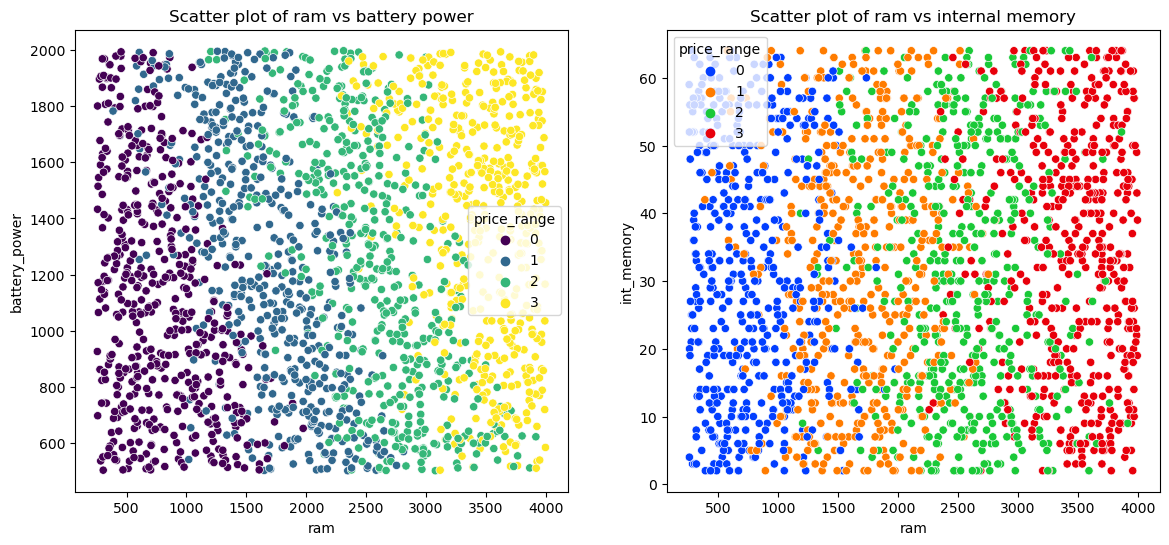

In [26]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='ram',y='battery_power',data=cp_df,palette='viridis',hue='price_range',ax=ax)
ax.set_title('Scatter plot of ram vs battery power')

ax = f.add_subplot(122)
sns.scatterplot(x='ram',y='int_memory',data=cp_df,palette='bright',hue='price_range')
ax.set_title('Scatter plot of ram vs internal memory')

Text(0.5, 1.0, 'Scatter plot of ram vs pixel width')

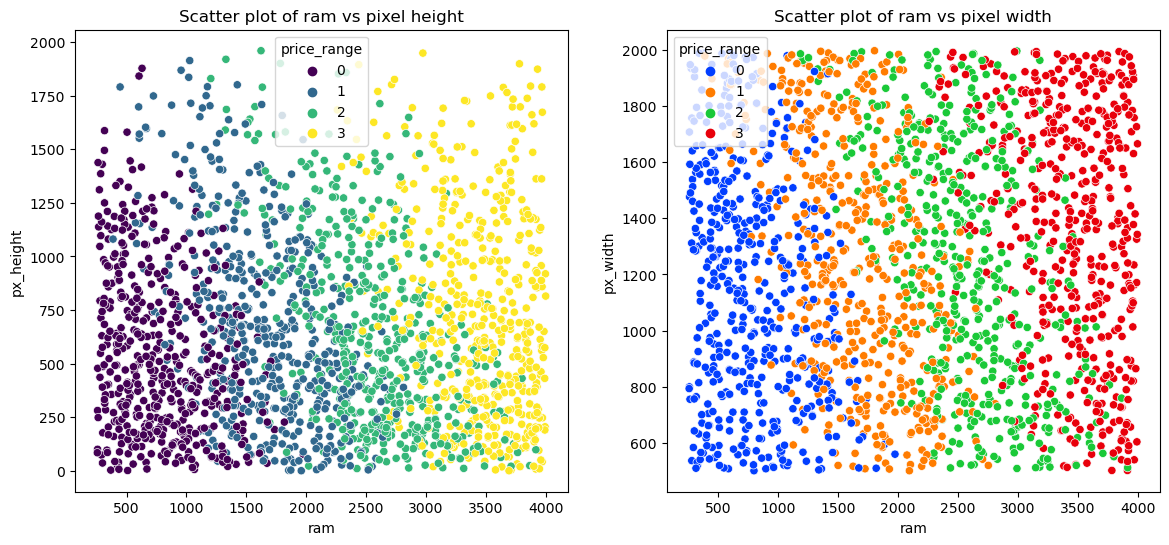

In [27]:

f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='ram',y='px_height',data=cp_df,palette='viridis',hue='price_range',ax=ax)
ax.set_title('Scatter plot of ram vs pixel height')

ax = f.add_subplot(122)
sns.scatterplot(x='ram',y='px_width',data=cp_df,palette='bright',hue='price_range')
ax.set_title('Scatter plot of ram vs pixel width')


Text(0.5, 1.0, 'Strip plot of ram vs 3G')

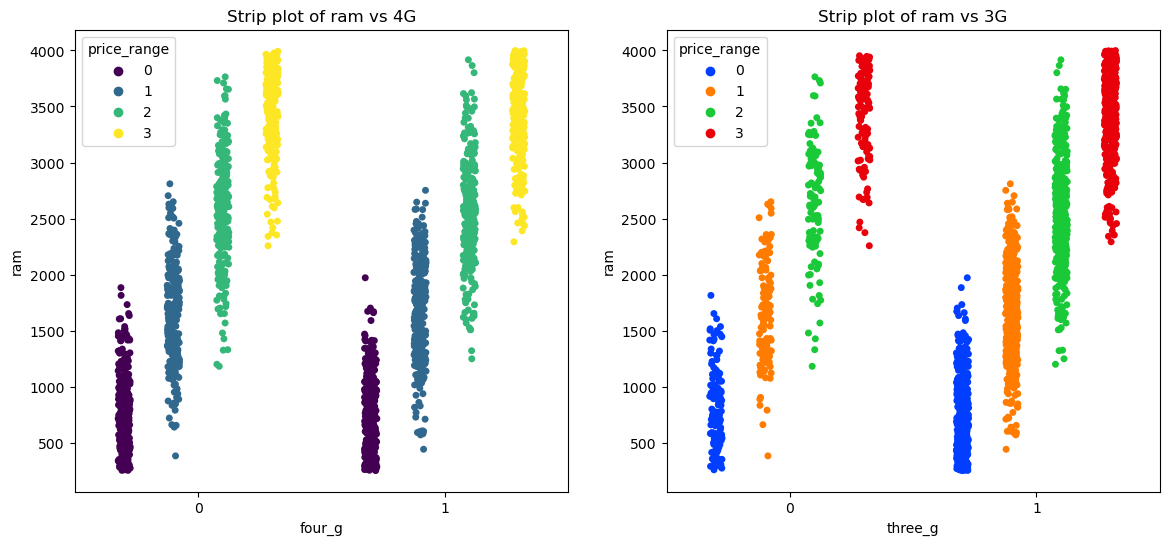

In [28]:

f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.stripplot(x='four_g',y='ram',data=cp_df,palette='viridis',hue='price_range',ax=ax, dodge=True)
ax.set_title('Strip plot of ram vs 4G')

ax = f.add_subplot(122)
sns.stripplot(x='three_g',y='ram',data=cp_df,palette='bright',hue='price_range', dodge=True)
ax.set_title('Strip plot of ram vs 3G')

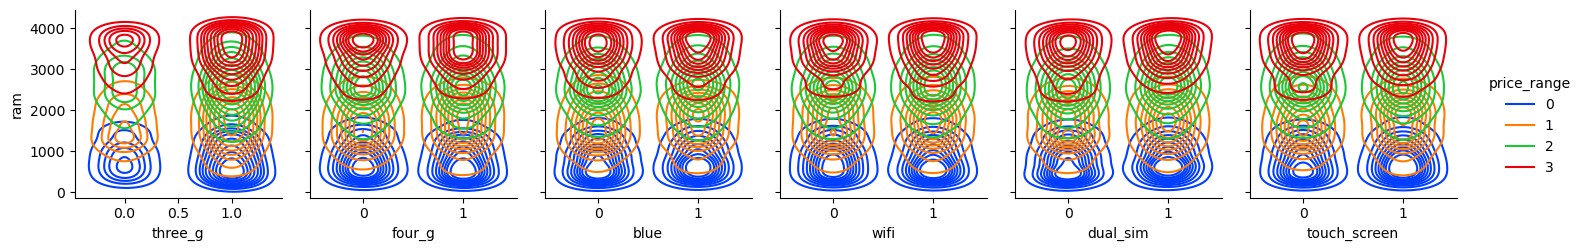

In [29]:

corr_list = cp_df.corr()['price_range'].sort_values(ascending=False)
corr_list = corr_list.index.to_list()
remaining = corr_list[6:]
# remaining.append('price_range')
# remaining.append('ram')

sns.pairplot(cp_df,
            hue='price_range',
            y_vars=['ram'],
            x_vars=['three_g','four_g', 'blue','wifi','dual_sim','touch_screen'], 
            palette='bright',
            kind='kde'
              )


## ML

In [30]:
X = cp_df.drop(['price_range'], axis=1)
y = cp_df['price_range']

### Normalization

In [31]:
# Split the dataset into train and test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_norm = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test_norm = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwa

In [32]:
X_train_norm

battery_power  blue  clock_speed  dual_sim        fc  four_g  \
0          0.226756   0.0         0.68       0.0  0.052632     0.0   
816        0.202007   1.0         0.08       0.0  0.000000     0.0   
790        0.272910   1.0         0.96       0.0  0.000000     0.0   
361        0.264883   0.0         0.00       1.0  0.684211     1.0   
592        0.508361   0.0         0.00       0.0  0.631579     0.0   
...             ...   ...          ...       ...       ...     ...   
1791       0.468227   1.0         0.00       1.0  0.000000     1.0   
1096       0.435452   0.0         0.60       0.0  0.315789     1.0   
1932       0.143813   1.0         0.44       1.0  0.052632     1.0   
235        0.682274   1.0         0.52       0.0  0.315789     1.0   
1061       0.681605   1.0         0.08       1.0  0.210526     0.0   

      int_memory     m_dep  mobile_wt   n_cores    pc  px_height  px_width  \
0       0.080645  0.555556   0.900000  0.142857  0.10   0.010204  0.170895   
816     1.000000  0.000000   0.141667  0.428571  0.70   0.327041  0.136182   
790     0.709677  0.000000   0.841667  0.571429  0.05   0.235204  0.113485   
361     0.887097  0.888889   0.766667  0.142857  0.90   0.402041  0.554740   
592     1.000000  0.222222   0.791667  0.571429  0.90   0.090816  0.923231   
...          ...       ...        ...       ...   ...        ...       ...   
1791    0.145161  0.888889   0.241667  0.142857  0.60   0.017857  0.006676   
1096    0.532258  0.777778   0.658333  0.571429  0.80   0.511735  0.885848   
1932    0.451613  0.333333   0.108333  0.285714  0.60   0.337755  0.331776   
235     0.145161  0.000000   0.408333  0.000000  0.40   0.075510  0.738318   
1061    0.419355  0.111111   0.366667  0.000000  0.25   0.485714  0.461282   

           ram      sc_h      sc_w  talk_time  three_g  touch_screen  wifi  
0     0.612774  0.285714  0.388889   0.944444      0.0           0.0   1.0  
816   0.043292  0.428571  0.333333   0.833333      0.0           1.0   1.0  
790   0.028594  0.285714  0.277778   0.833333      0.0           1.0   0.0  
361   0.028862  0.428571  0.055556   0.277778      1.0           1.0   0.0  
592   0.247728  0.642857  0.166667   0.833333      0.0           0.0   1.0  
...        ...       ...       ...        ...      ...           ...   ...  
1791  0.378407  0.857143  0.722222   0.944444      1.0           1.0   0.0  
1096  0.803314  0.785714  0.833333   0.777778      1.0           0.0   0.0  
1932  0.359433  0.357143  0.500000   0.555556      1.0           1.0   1.0  
235   0.120524  1.000000  0.444444   0.944444      1.0           1.0   0.0  
1061  0.297167  0.642857  0.277778   0.833333      1.0           0.0   1.0  

[1600 rows x 20 columns]

In [33]:

kernels = ['linear', 'poly','rbf', 'sigmoid']
svm_accuracy_score_kernels = []
# Training an SVM model
for kernel in kernels:
    svc = svm.SVC(kernel=kernel)
    svc.fit(X_train_norm, y_train)

    # Test the trained SVM model on the test set and compute accuracy
    y_pred = svc.predict(X_test_norm)
    svm_accuracy_score_kernels.append(metrics.accuracy_score(y_test, y_pred))
    print(f"SVM Accuracy({kernel}):",metrics.accuracy_score(y_test, y_pred))

SVM Accuracy(linear): 0.9375
SVM Accuracy(poly): 0.87
SVM Accuracy(rbf): 0.8425
SVM Accuracy(sigmoid): 0.205


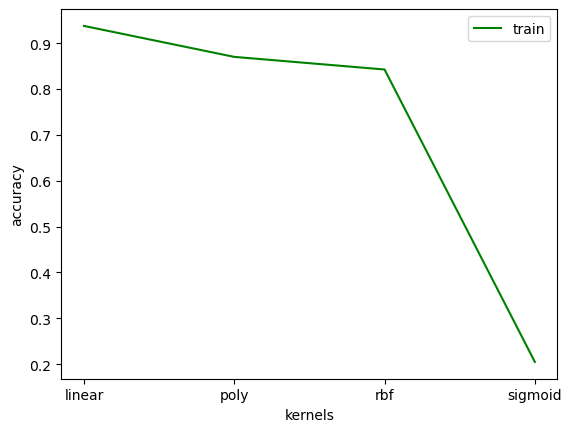

In [34]:
plt.plot(kernels,svm_accuracy_score_kernels,color="green",label="train")
plt.xlabel("kernels")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier

criterions = ['gini', 'entropy', 'log_loss']
rf_accuracy_score_criterions = []
for criterion in criterions:
    # Training a random forrest model
    rf = RandomForestClassifier(criterion=criterion)
    rf.fit(X_train_norm, y_train)

    # Test the trained RF model on the test set and compute accuracy
    y_pred = rf.predict(X_test_norm)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    rf_accuracy_score_criterions.append(accuracy)
    print(f"Random Forest Accuracy({criterion}):",accuracy)

Random Forest Accuracy(gini): 0.8625
Random Forest Accuracy(entropy): 0.8775
Random Forest Accuracy(log_loss): 0.865


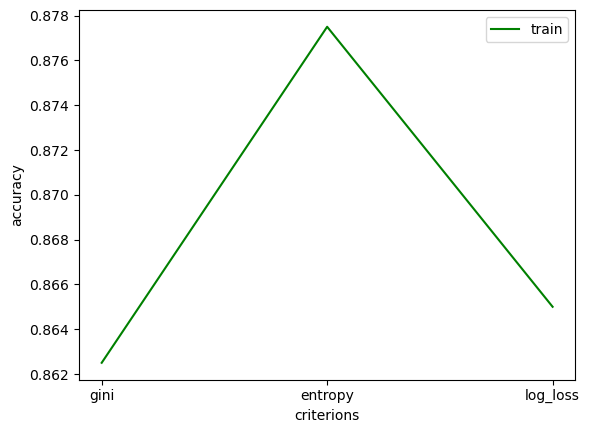

In [36]:

plt.plot(criterions,rf_accuracy_score_criterions,color="green",label="train")
plt.xlabel("criterions")
plt.ylabel("accuracy")
plt.legend()
plt.show()